<a href="https://colab.research.google.com/github/narayan-bhattarai/AI-Classification/blob/main/GastroVision_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install packages & imports**

In [ ]:
import os
import shutil
import zipfile
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

!pip install grad-cam > /dev/null
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

**Extract Dataset from ZIP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

zip_path = "/content/drive/MyDrive/GastroVision.zip"
extract_dir = "/content/GastroVision"

# Fresh extract
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

os.listdir(extract_dir)

['GastroVision']

In [ ]:
import os

for root, dirs, files in os.walk("/content/GastroVision", topdown=True):
    print(root, "->", dirs)

/content/GastroVision -> ['GastroVision']
/content/GastroVision/GastroVision -> ['Test dataset', 'Training data']
/content/GastroVision/GastroVision/Test dataset -> []
/content/GastroVision/GastroVision/Training data -> ['Normal mucosa and vascular pattern in the large bowel', 'Erythema', 'Colon polyps', 'Normal esophagus']
/content/GastroVision/GastroVision/Training data/Normal mucosa and vascular pattern in the large bowel -> []
/content/GastroVision/GastroVision/Training data/Erythema -> []
/content/GastroVision/GastroVision/Training data/Colon polyps -> []
/content/GastroVision/GastroVision/Training data/Normal esophagus -> []


**Train/Val Split**

In [ ]:


train_source = "/content/GastroVision/GastroVision/Training data"
test_source  = "/content/GastroVision/GastroVision/Test dataset"
output_dir   = "/content/GastroVisionSplit"

train_dir = os.path.join(output_dir, "train")
val_dir   = os.path.join(output_dir, "val")
test_dir  = os.path.join(output_dir, "test")  # keep test separate

# Reset split folder
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = os.listdir(train_source)

# SPLIT TRAINING DATA → train + val
for cls in classes:
    cls_path = os.path.join(train_source, cls)
    images = os.listdir(cls_path)

    train_imgs, val_imgs = train_test_split(images, test_size=0.20, random_state=42)

    # TRAIN
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(train_dir, cls, img))

    # VAL
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(val_dir, cls, img))

# COPY TEST IMAGES IN ONE FOLDER
for img in os.listdir(test_source):
    shutil.copy(os.path.join(test_source, img),
                os.path.join(test_dir, img))

print("Train/Val/Test split created successfully!")
print(os.listdir(output_dir))


Train/Val/Test split created successfully!
['train', 'val', 'test']


**Transforms + Dataset + DataLoaders**

In [ ]:
# ================================
# PATHS
# ================================
TRAIN_DIR = "/content/GastroVisionSplit/train"
VAL_DIR   = "/content/GastroVisionSplit/val"
TEST_DIR  = "/content/GastroVisionSplit/test"   # Correct test folder

# ================================
# TRANSFORMS
# ================================
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_tfms = val_tfms   # No augmentation for test

# ================================
# TRAIN / VAL Datasets
# ================================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_tfms)

class_names = train_dataset.classes
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
num_classes = len(class_names)

train_dataset, val_dataset, class_names


(Dataset ImageFolder
     Number of datapoints: 1953
     Root location: /content/GastroVisionSplit/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 489
     Root location: /content/GastroVisionSplit/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 ['Colon polyps',
  'Eryt

**TestDataset Class + DataLoaders**

In [ ]:

# ================================
# Custom Dataset for Test Images
# ================================
class GastroVisionTestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = sorted([
            f for f in os.listdir(folder)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.folder, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name


# ================================
# DATA LOADERS
# ================================
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

test_dataset = GastroVisionTestDataset(TEST_DIR, transform=test_tfms)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

len(train_dataset), len(val_dataset), len(test_dataset)


(1953, 489, 160)

**Model Factory**

In [ ]:

def create_model(model_name, num_classes):

    if model_name == "mobilenetv3":
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model.to(device)


# Create all 3 models
models_dict = {
    "MobileNetV3": create_model("mobilenetv3", num_classes),
    "EfficientNetB0": create_model("efficientnet_b0", num_classes),
    "ResNet50": create_model("resnet50", num_classes),
}

models_dict


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 164MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 161MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


{'MobileNetV3': MobileNetV3(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       (2): Hardswish()
     )
     (1): InvertedResidual(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
           (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
           (2): ReLU(inplace=True)
         )
         (1): Conv2dNormActivation(
           (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
         )
       )
     )
     (2): InvertedResidual(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(16, 64

**Loss, Optimizer & Scheduler Setup**

In [ ]:
def create_trainer_components(model, class_weights):
    """Returns criterion, optimizer, scheduler for a given model."""

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3
    )

    return criterion, optimizer, scheduler


**Training + Validation Functions**

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # metrics
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds


In [ ]:


def evaluate_metrics(labels, preds, class_names):
    macro_f1 = f1_score(labels, preds, average="macro")

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(labels, preds))

    return macro_f1


**Full Training Loop (Runs for Each Model)**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, model_name, num_epochs=20):
    best_f1 = 0.0
    best_path = f"/content/best_{model_name}.pth"

    print(f"\n=== Training {model_name} ===")

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, labels, preds = validate_one_epoch(model, val_loader, criterion, device)
        val_f1 = evaluate_metrics(labels, preds, class_names)

        scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_path)

            print("\n🔥 NEW BEST MODEL FOUND!")
            print(f"F1 Score: {val_f1:.4f}")
            print(f"Model saved to: {best_path}")

    print(f"\nTraining complete. Best F1: {best_f1:.4f}")
    return best_path


In [ ]:
from collections import Counter
import torch

# Make sure train_dataset and device are already defined before this.
print("Device:", device)

# 1) Count how many samples per class in the TRAIN dataset
targets = [label for _, label in train_dataset.samples]
class_counts = Counter(targets)
print("Class counts:", class_counts)

# 2) Build weights = 1 / count for each class index 0..num_classes-1
class_weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(len(class_counts))],
    dtype=torch.float
).to(device)

print("Class weights:", class_weights)


Device: cuda
Class counts: Counter({3: 1173, 0: 656, 2: 112, 1: 12})
Class weights: tensor([0.0015, 0.0833, 0.0089, 0.0009], device='cuda:0')


In [ ]:
# MobileNetV3
model = models_dict["MobileNetV3"]

# Create loss, optimizer, scheduler for THIS model
criterion, optimizer, scheduler = create_trainer_components(model, class_weights)

# Train the model
best_mobilenet_path = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    model_name="MobileNetV3",
    num_epochs=20  # you can change to 5–10 to test faster
)

print("Best MobileNetV3 model saved at:", best_mobilenet_path)



=== Training MobileNetV3 ===

Epoch 1/20

Classification Report:
                                                       precision    recall  f1-score   support

                                         Colon polyps       0.66      0.90      0.76       164
                                             Erythema       0.00      0.00      0.00         3
                                     Normal esophagus       1.00      0.96      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.93      0.76      0.83       294

                                             accuracy                           0.81       489
                                            macro avg       0.65      0.65      0.64       489
                                         weighted avg       0.84      0.81      0.81       489


Confusion Matrix:
[[147   1   0  16]
 [  3   0   0   0]
 [  1   0  27   0]
 [ 72   0   0 222]]

🔥 NEW BEST MODEL FOUND!
F1 Score: 0.6440
Model saved to: /content/best_Mob

In [ ]:
model = models_dict["EfficientNetB0"]

criterion, optimizer, scheduler = create_trainer_components(model, class_weights)

best_efficientnet_path = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    model_name="EfficientNetB0",
    num_epochs=20
)

print("Best EfficientNet-B0 model saved at:", best_efficientnet_path)



=== Training EfficientNetB0 ===

Epoch 1/20

Classification Report:
                                                       precision    recall  f1-score   support

                                         Colon polyps       0.63      0.89      0.74       164
                                             Erythema       0.43      1.00      0.60         3
                                     Normal esophagus       0.82      1.00      0.90        28
Normal mucosa and vascular pattern in the large bowel       0.93      0.69      0.79       294

                                             accuracy                           0.78       489
                                            macro avg       0.70      0.90      0.76       489
                                         weighted avg       0.82      0.78      0.78       489


Confusion Matrix:
[[146   1   2  15]
 [  0   3   0   0]
 [  0   0  28   0]
 [ 84   3   4 203]]

🔥 NEW BEST MODEL FOUND!
F1 Score: 0.7593
Model saved to: /content/best_

In [ ]:
model = models_dict["ResNet50"]

criterion, optimizer, scheduler = create_trainer_components(model, class_weights)

best_resnet_path = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    model_name="ResNet50",
    num_epochs=20
)

print("Best ResNet50 model saved at:", best_resnet_path)



=== Training ResNet50 ===

Epoch 1/20

Classification Report:
                                                       precision    recall  f1-score   support

                                         Colon polyps       0.53      1.00      0.69       164
                                             Erythema       0.00      0.00      0.00         3
                                     Normal esophagus       0.90      1.00      0.95        28
Normal mucosa and vascular pattern in the large bowel       1.00      0.50      0.67       294

                                             accuracy                           0.70       489
                                            macro avg       0.61      0.63      0.58       489
                                         weighted avg       0.83      0.70      0.69       489


Confusion Matrix:
[[164   0   0   0]
 [  2   0   1   0]
 [  0   0  28   0]
 [144   0   2 148]]

🔥 NEW BEST MODEL FOUND!
F1 Score: 0.5777
Model saved to: /content/best_ResNet

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
                                                       precision    recall  f1-score   support

                                         Colon polyps       0.53      0.65      0.58       164
                                             Erythema       0.03      0.67      0.05         3
                                     Normal esophagus       0.90      1.00      0.95        28
Normal mucosa and vascular pattern in the large bowel       0.96      0.61      0.75       294

                                             accuracy                           0.65       489
                                            macro avg       0.61      0.73      0.58       489
                                         weighted avg       0.81      0.65      0.70       489


Confusion Matrix:
[[106  51   0   7]
 [  0   2   0   1]
 [  0   0  28   0]
 [ 93  18   3 180]]

🔥 NEW BEST MODEL FOUND!
F1 Score: 0.5835
Model saved to: /content/best_ResNet50.pth

Epoch 3/20

Classification Repo

Load Best Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 4  # Colon polyps, Erythema, Normal esophagus, Normal mucosa

# Load EfficientNet-B0 architecture
model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load weights
best_model_path = "/content/best_EfficientNetB0.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

print("Loaded best EfficientNet-B0 model!")


Loaded best EfficientNet-B0 model!


In [ ]:
import os
from PIL import Image

TEST_DIR = "/content/GastroVision/GastroVision/Test dataset"

test_images = sorted(os.listdir(TEST_DIR))
print("Total test images:", len(test_images))


Total test images: 160


In [ ]:
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = test_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    return pred.item()


In [ ]:
import pandas as pd

results = []

for img_name in test_images:
    img_path = os.path.join(TEST_DIR, img_name)
    pred_idx = predict_image(img_path)
    pred_label = class_names[pred_idx]

    results.append({
        "image_id": img_name,
        "label": pred_label
    })

df = pd.DataFrame(results)
df.to_csv("submission_narayan.csv", index=False)

print("Saved submission_narayan.csv")
df.head()


Saved submission_narayan.csv


,image_id,label
0,000f345f-8a6d-48ec-a73c-a85a1ca193bb.jpg,Normal esophagus
1,00a33b94-f7ab-4739-a88e-5d9dbe2c6cc1.jpg,Normal esophagus
2,00a79db4-e443-4d10-9f76-b4b82e7780de.jpg,Normal esophagus
3,00b66a20-6b31-4481-b628-6e42a75cc9cb.jpg,Normal mucosa and vascular pattern in the larg...
4,00bc24cd-0e00-49c3-9b7e-d2dbf81ea7e5.jpg,Normal mucosa and vascular pattern in the larg...


In [ ]:
target_layer = model.features[-1][0]   # Last convolution block


In [ ]:
TEST_DIR = "/content/GastroVision/GastroVision/Test dataset"
test_images = sorted(os.listdir(TEST_DIR))

len(test_images), test_images[:5]


(160,
 ['000f345f-8a6d-48ec-a73c-a85a1ca193bb.jpg',
  '00a33b94-f7ab-4739-a88e-5d9dbe2c6cc1.jpg',
  '00a79db4-e443-4d10-9f76-b4b82e7780de.jpg',
  '00b66a20-6b31-4481-b628-6e42a75cc9cb.jpg',
  '00bc24cd-0e00-49c3-9b7e-d2dbf81ea7e5.jpg'])

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def gradcam_single(img_path, model):
    # Load original image
    img = Image.open(img_path).convert("RGB")
    orig = np.array(img)
    H, W, _ = orig.shape

    # Transform for model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    input_tensor = transform(img).unsqueeze(0).to(device)

    # EfficientNet-B0 target layer
    target_layer = model.features[-1]

    # Create CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Get raw CAM mask
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Resize CAM to original image size
    grayscale_cam_resized = cv2.resize(grayscale_cam, (W, H))

    # Normalize original image to [0,1]
    rgb_img = orig.astype(np.float32) / 255.0

    # Overlay heatmap
    heatmap = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

    return orig, grayscale_cam_resized, heatmap


In [ ]:
def show_gradcam_by_index(index):
    if index < 0 or index >= len(test_images):
        print("❌ Invalid index!")
        return

    img_name = test_images[index]
    img_path = os.path.join(TEST_DIR, img_name)

    print(f"Showing Grad-CAM for index {index}: {img_name}")

    orig, mask, heatmap = gradcam_single(img_path, model)

    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(orig)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("CAM Mask")
    plt.imshow(mask, cmap="jet")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Grad-CAM Overlay")
    plt.imshow(heatmap)
    plt.axis("off")

    plt.show()


Showing Grad-CAM for index 130: cju5ddda9bkkt0850enzwatb1.jpg


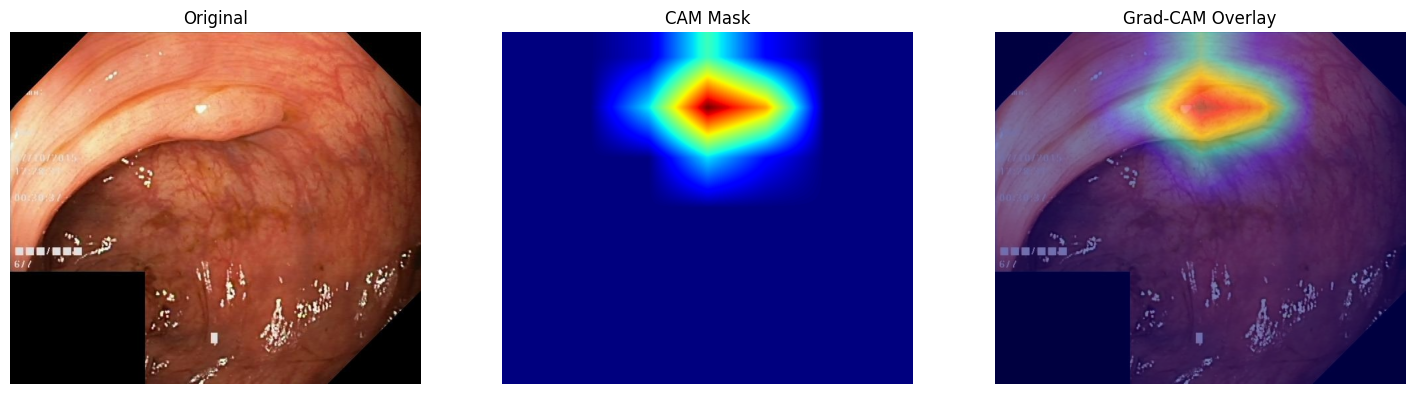

In [ ]:
show_gradcam_by_index(130)


In [ ]:
history_mobilenet = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}


In [ ]:
history_mobilenet = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}


In [ ]:
history_resnet = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}


In [ ]:
NUM_EPOCHS = 20
def train_model(model, criterion, optimizer, scheduler, history_dict):
    best_f1 = 0.0
    best_path = None

    for epoch in range(1, NUM_EPOCHS + 1):
        # TRAIN
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # VALID
        val_loss, val_acc, labels, preds = validate_one_epoch(model, val_loader, criterion, device)

        # METRIC
        val_f1 = f1_score(labels, preds, average="macro")

        # SAVE HISTORY
        history_dict["loss"].append(train_loss)
        history_dict["val_loss"].append(val_loss)
        history_dict["acc"].append(train_acc)
        history_dict["val_acc"].append(val_acc)

        # Scheduler
        scheduler.step(val_f1)

        # Print & save best
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_path = f"/content/best_{model.__class__.__name__}.pth"
            torch.save(model.state_dict(), best_path)

            print("\n🔥 NEW BEST MODEL FOUND!")
            print(f"Epoch: {epoch}")
            print(f"F1 Score: {best_f1:.4f}")
            print(f"Model saved to: {best_path}")

    print("\nTraining complete. Best F1:", best_f1)
    return best_path



In [ ]:
history_mobilenet = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}

path_mobilenet = train_model(
    models_dict["MobileNetV3"],
    *create_trainer_components(models_dict["MobileNetV3"], class_weights),
    history_mobilenet
)



🔥 NEW BEST MODEL FOUND!
Epoch: 1
F1 Score: 0.8760
Model saved to: /content/best_MobileNetV3.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 6
F1 Score: 0.9103
Model saved to: /content/best_MobileNetV3.pth

Training complete. Best F1: 0.9102572765072765


In [ ]:
history_efficient = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}

path_efficient = train_model(
    models_dict["EfficientNetB0"],
    *create_trainer_components(models_dict["EfficientNetB0"], class_weights),
    history_efficient
)

print("Best EfficientNet-B0 saved at:", path_efficient)



🔥 NEW BEST MODEL FOUND!
Epoch: 1
F1 Score: 0.8428
Model saved to: /content/best_EfficientNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 2
F1 Score: 0.8783
Model saved to: /content/best_EfficientNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 4
F1 Score: 0.9241
Model saved to: /content/best_EfficientNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 5
F1 Score: 0.9267
Model saved to: /content/best_EfficientNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 6
F1 Score: 0.9297
Model saved to: /content/best_EfficientNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 8
F1 Score: 0.9644
Model saved to: /content/best_EfficientNet.pth

Training complete. Best F1: 0.9643786038522881
Best EfficientNet-B0 saved at: /content/best_EfficientNet.pth


In [ ]:
history_resnet = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}

path_resnet = train_model(
    models_dict["ResNet50"],
    *create_trainer_components(models_dict["ResNet50"], class_weights),
    history_resnet
)

print("Best ResNet50 saved at:", path_resnet)



🔥 NEW BEST MODEL FOUND!
Epoch: 1
F1 Score: 0.7996
Model saved to: /content/best_ResNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 2
F1 Score: 0.8474
Model saved to: /content/best_ResNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 3
F1 Score: 0.9059
Model saved to: /content/best_ResNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 4
F1 Score: 0.9139
Model saved to: /content/best_ResNet.pth

🔥 NEW BEST MODEL FOUND!
Epoch: 12
F1 Score: 0.9209
Model saved to: /content/best_ResNet.pth

Training complete. Best F1: 0.9209418524764225
Best ResNet50 saved at: /content/best_ResNet.pth


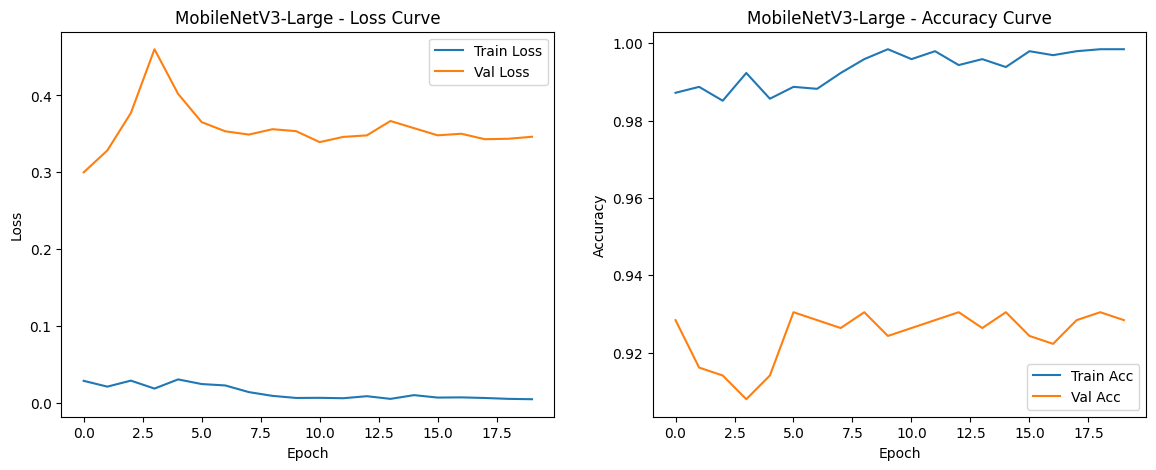

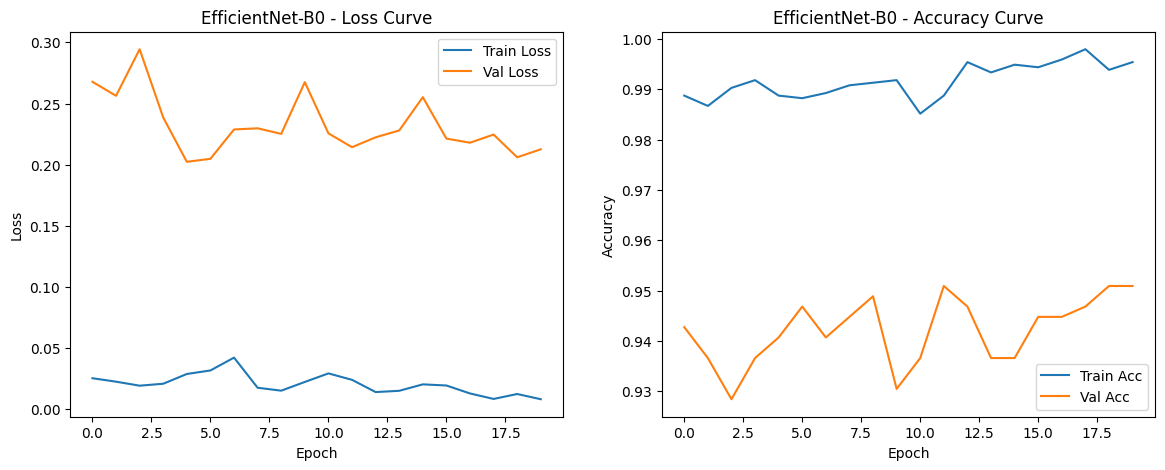

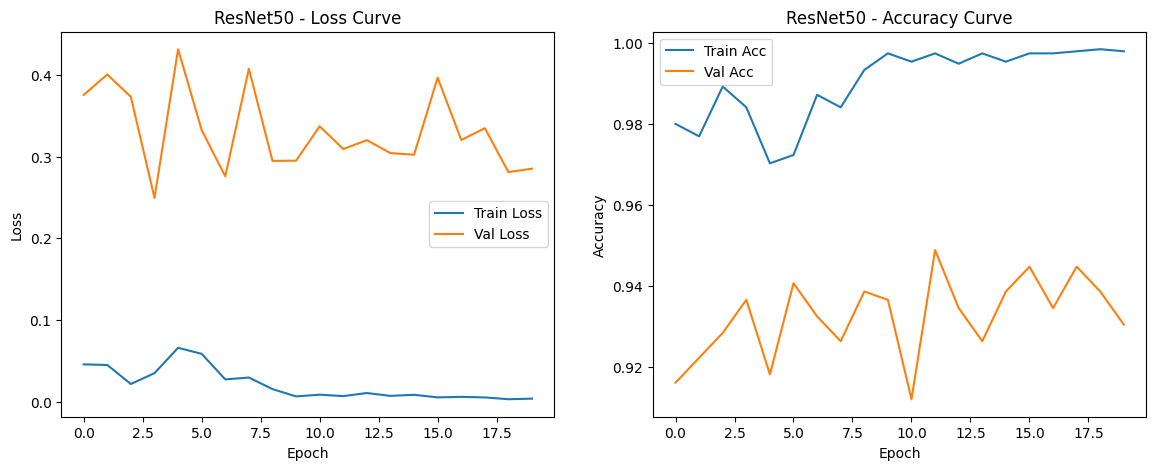

In [ ]:
def plot_history(title, history):
    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history["acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"{title} - Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


# Plot for each
plot_history("MobileNetV3-Large", history_mobilenet)
plot_history("EfficientNet-B0", history_efficient)
plot_history("ResNet50", history_resnet)


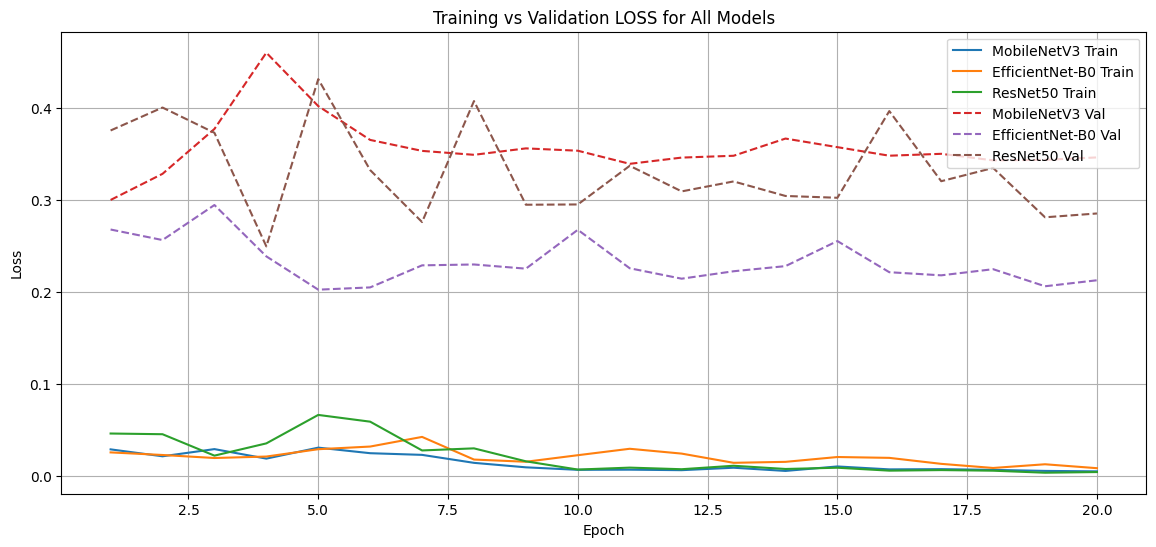

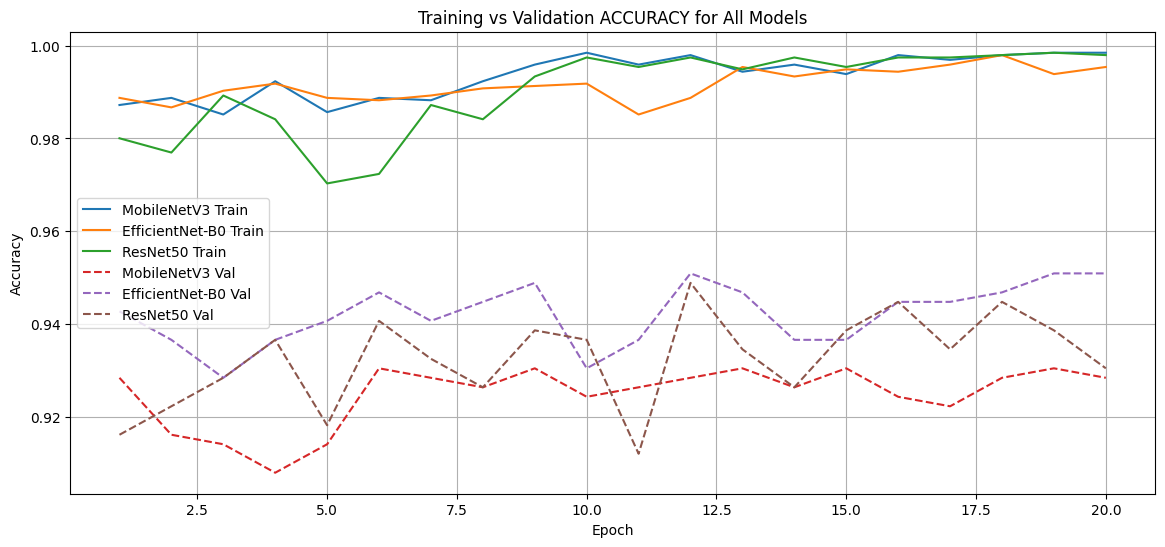

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_histories(hist_mobile, hist_eff, hist_res):
    epochs = range(1, len(hist_mobile["loss"]) + 1)

    # =======================
    # 📌 Combined LOSS plot
    # =======================
    plt.figure(figsize=(14,6))
    plt.title("Training vs Validation LOSS for All Models")

    # Training loss
    plt.plot(epochs, hist_mobile["loss"], label="MobileNetV3 Train")
    plt.plot(epochs, hist_eff["loss"], label="EfficientNet-B0 Train")
    plt.plot(epochs, hist_res["loss"], label="ResNet50 Train")

    # Validation loss
    plt.plot(epochs, hist_mobile["val_loss"], "--", label="MobileNetV3 Val")
    plt.plot(epochs, hist_eff["val_loss"], "--", label="EfficientNet-B0 Val")
    plt.plot(epochs, hist_res["val_loss"], "--", label="ResNet50 Val")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


    # =======================
    # 📌 Combined ACCURACY plot
    # =======================
    plt.figure(figsize=(14,6))
    plt.title("Training vs Validation ACCURACY for All Models")

    # Training accuracy
    plt.plot(epochs, hist_mobile["acc"], label="MobileNetV3 Train")
    plt.plot(epochs, hist_eff["acc"], label="EfficientNet-B0 Train")
    plt.plot(epochs, hist_res["acc"], label="ResNet50 Train")

    # Validation accuracy
    plt.plot(epochs, hist_mobile["val_acc"], "--", label="MobileNetV3 Val")
    plt.plot(epochs, hist_eff["val_acc"], "--", label="EfficientNet-B0 Val")
    plt.plot(epochs, hist_res["val_acc"], "--", label="ResNet50 Val")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


# Call function
plot_combined_histories(history_mobilenet, history_efficient, history_resnet)


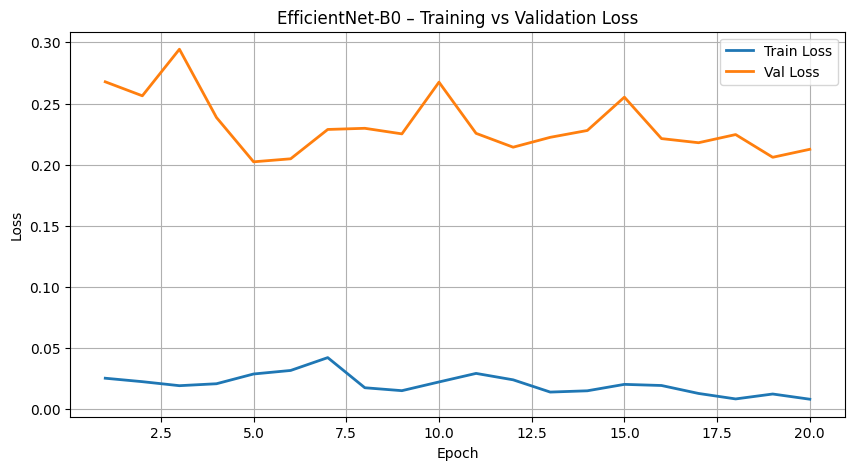

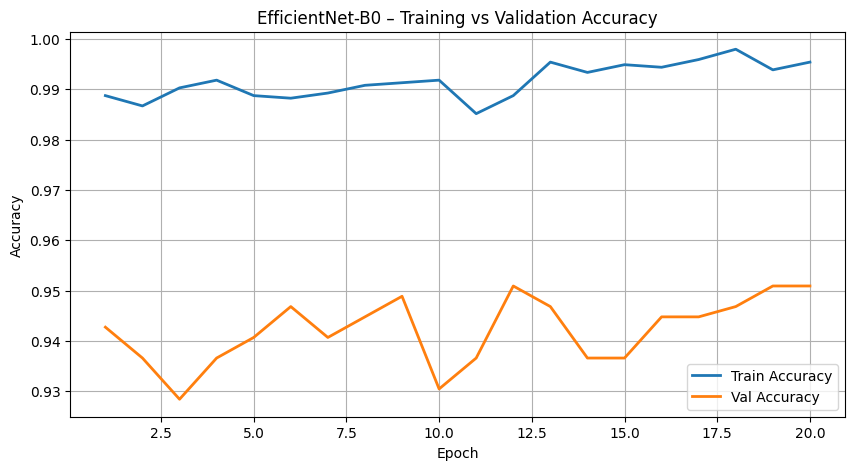

In [ ]:
import matplotlib.pyplot as plt

def plot_best_model_history(history, model_name="EfficientNet-B0"):
    epochs = range(1, len(history["loss"]) + 1)

    # =======================
    # 📉 LOSS curve
    # =======================
    plt.figure(figsize=(10,5))
    plt.plot(epochs, history["loss"], label="Train Loss", linewidth=2)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linewidth=2)

    plt.title(f"{model_name} – Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # =======================
    # 📈 ACCURACY curve
    # =======================
    plt.figure(figsize=(10,5))
    plt.plot(epochs, history["acc"], label="Train Accuracy", linewidth=2)
    plt.plot(epochs, history["val_acc"], label="Val Accuracy", linewidth=2)

    plt.title(f"{model_name} – Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()


# Call it for EfficientNet-B0
plot_best_model_history(history_efficient, "EfficientNet-B0")


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

model = models_dict["EfficientNetB0"]
model.load_state_dict(torch.load("/content/best_EfficientNetB0.pth"))
model.eval()
model.to(device)

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)


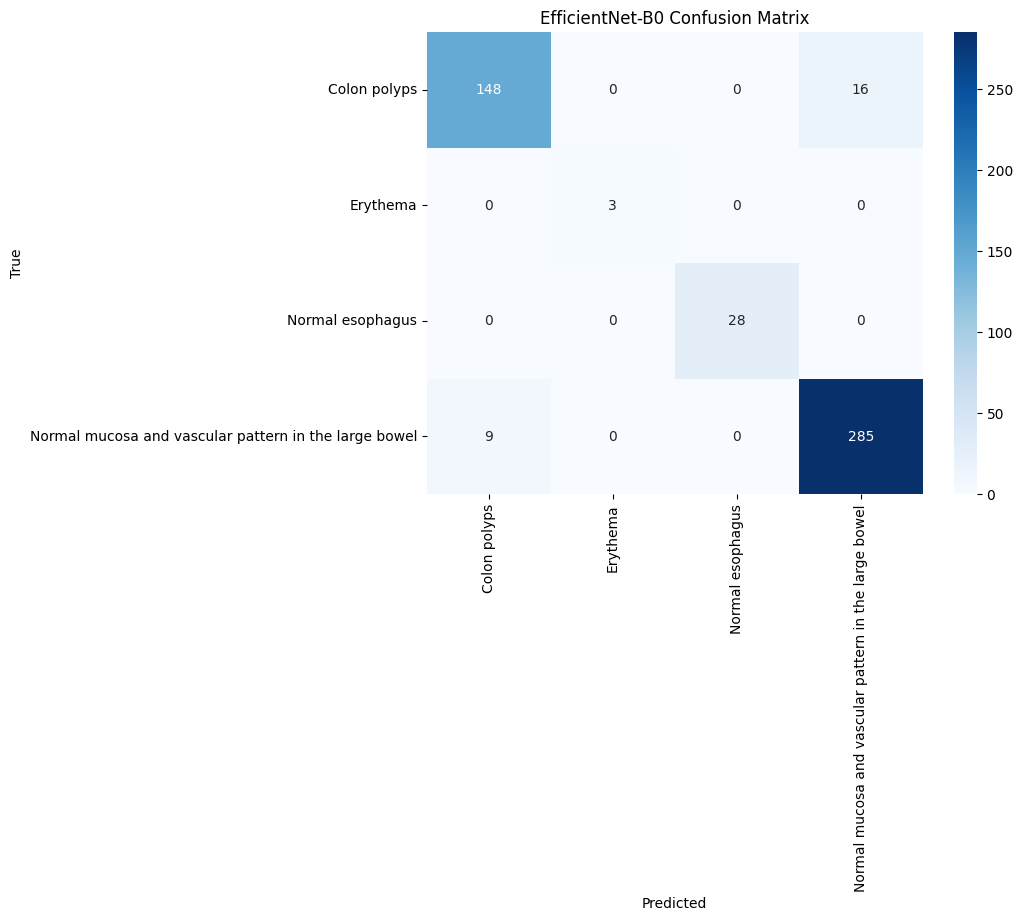

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("EfficientNet-B0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


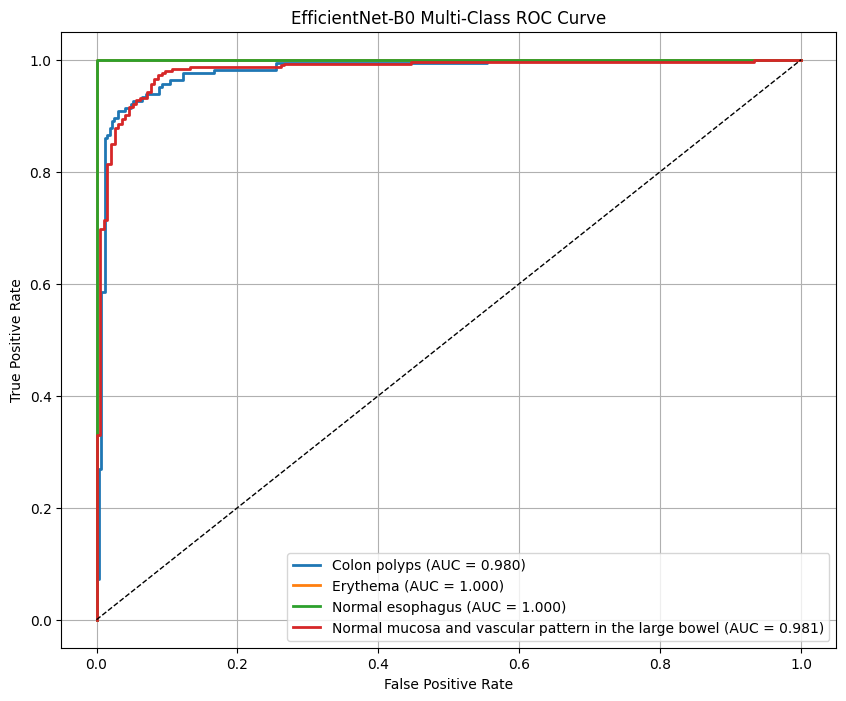

In [ ]:
from sklearn.preprocessing import label_binarize

# Convert labels → one-hot for ROC
labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

plt.figure(figsize=(10,8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNet-B0 Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
